# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

In [70]:
# Install dependencies (run this only if you need to install 3rd party applications)

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install networkx

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from abstract_udmis import AbstractUDMIS

%matplotlib inline

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

In [72]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        

In [73]:
def draw_graph_state(graph,occupations, ax):
    G = nx.from_numpy_array(graph.edges)
    graph_np = np.array(graph.graph)
    x_vals = graph_np[:,0]
    y_vals = graph_np[:,1]

    colormap = []
    for x,y,occ in zip(x_vals,y_vals,occupations):
        color = 'red' if occ else 'black'
        colormap.append(color)
        circle = plt.Circle((x,y), 0.5, color='gray', alpha=0.1)
        ax.add_patch(circle)
    nx.draw(G, pos=graph.graph, node_color=colormap, edge_color='b',ax=ax)
    ax.axis('equal')
    print(graph.graph)


6
[(0.3461717838632017, 1.4984640297338632), (0.6316400411846113, 2.5754677320579895), (1.3906262250927481, 2.164978861396621), (0.66436005100802, 0.6717919819739032), (0.8663329771713457, 3.3876341010035995), (1.1643107343501296, 1.0823066243402013)]


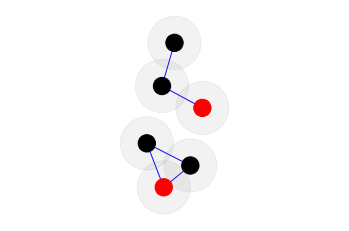

In [74]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)
fig, ax = plt.subplots()

draw_graph_state(udmis, udmis.occupations, ax)

In [75]:
def plot_coefficients(annealing_type, N, ti, tf):

    t = np.arange(N+1)
    if annealing_type == 'original':
        T = ti * ((tf/ti) ** (t/N))
    if annealing_type == 'inverse':
        T = ti / (t + 1)
    if annealing_type == 'inverse_log':
        T = ti/(1 + np.log(1+t))
    if annealing_type == 'exponential':
        T = ti * ((tf/ti) ** (t/N))/(t+1)

    x = []
    y = []
    tmp = [] # Temperature
    for t in range(N):
        if t%80 == 0:   #sample every 80 steps, modify as appropriate
            temp = T[t]
            E = udmis.mc_step(T=temp)
            x.append(t)
            y.append(E)
            tmp.append(temp)
    return x,y,tmp
    
        

# Number of iterations
N = 5000

# Trial parameters
T_i = 100
T_f_1 = 0.1
T_f_2 = 0.01
T_f_3 = 0.001
T_f_4 = 0.0001
T_f_5 = 0.00001
T_f_6 = 0.000001

## Original Annealing Schedule
In this section, we'll use the original annealing schedule (ie. T = ti * ((tf/ti) ** (t/N)))

In [56]:
# Grab our data points
(x1,y1,T1) = plot_coefficients('original', N, T_i, T_f_1)
(x2,y2,T2) = plot_coefficients('original', N, T_i, T_f_2)
(x3,y3,T3) = plot_coefficients('original', N, T_i, T_f_3)
(x4,y4,T4) = plot_coefficients('original', N, T_i, T_f_4)
(x5,y5,T5) = plot_coefficients('original', N, T_i, T_f_5)
(x6,y6,T6) = plot_coefficients('original', N, T_i, T_f_6)

[Text(0, 0.5, 'energy'), Text(0, 0.5, 'energy')]

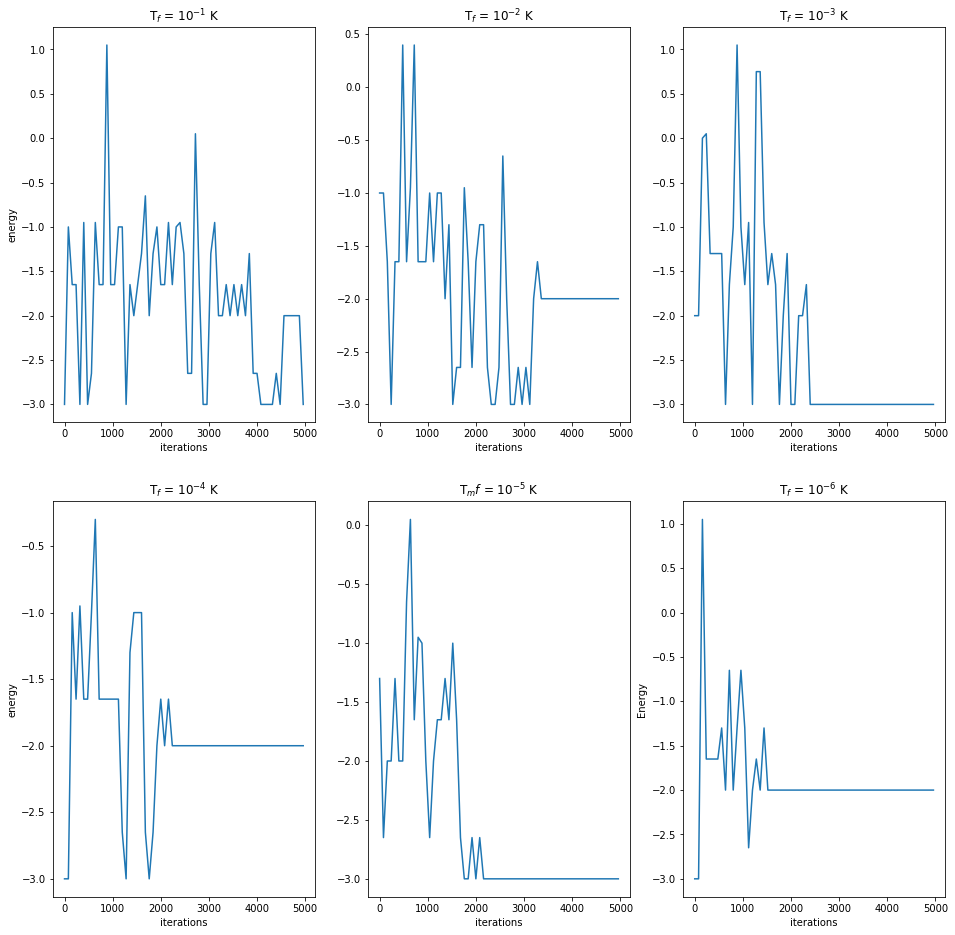

In [57]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(16,16))

axis[0,0].plot(x1,y1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,y2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,y3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,y4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,y5)
axis[1,1].set_title("T$_m{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,y6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")
plt.xlabel('iterations')
plt.ylabel('Energy')

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='energy')

[Text(0, 0.5, 'temperature'), Text(0, 0.5, 'temperature')]

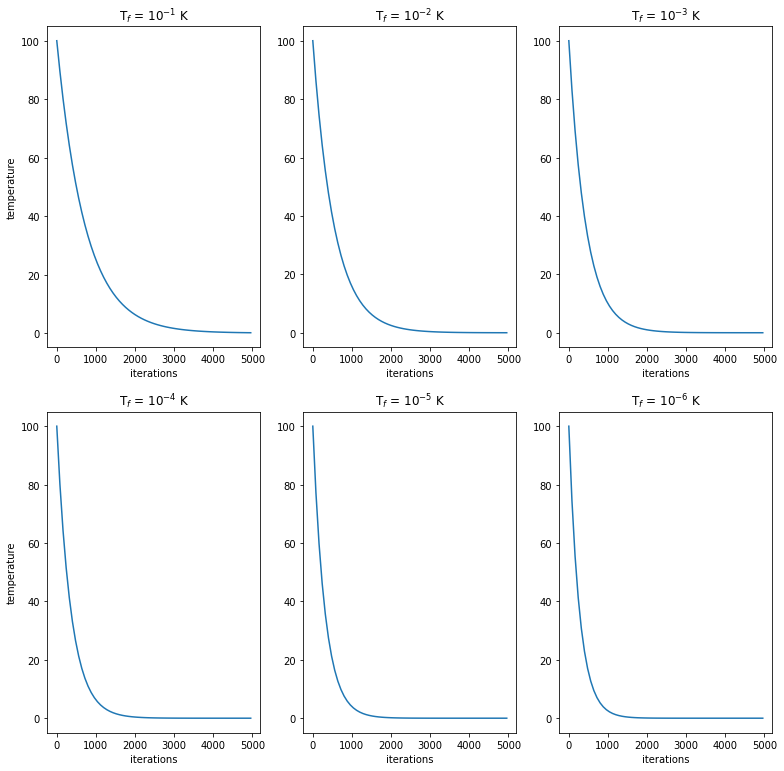

In [58]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(13,13))

axis[0,0].plot(x1,T1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,T2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,T3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,T4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,T5)
axis[1,1].set_title("T$_{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,T6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='temperature')

## Inverse Annealing Schedule
In this section, we'll use the inverse annealing schedule (ie. T =  ti / (t + 1))

In [59]:
# Grab our data points
(x1,y1,T1) = plot_coefficients('inverse', N, T_i, T_f_1)
(x2,y2,T2) = plot_coefficients('inverse', N, T_i, T_f_2)
(x3,y3,T3) = plot_coefficients('inverse', N, T_i, T_f_3)
(x4,y4,T4) = plot_coefficients('inverse', N, T_i, T_f_4)
(x5,y5,T5) = plot_coefficients('inverse', N, T_i, T_f_5)
(x6,y6,T6) = plot_coefficients('inverse', N, T_i, T_f_6)

[Text(0, 0.5, 'energy'), Text(0, 0.5, 'energy')]

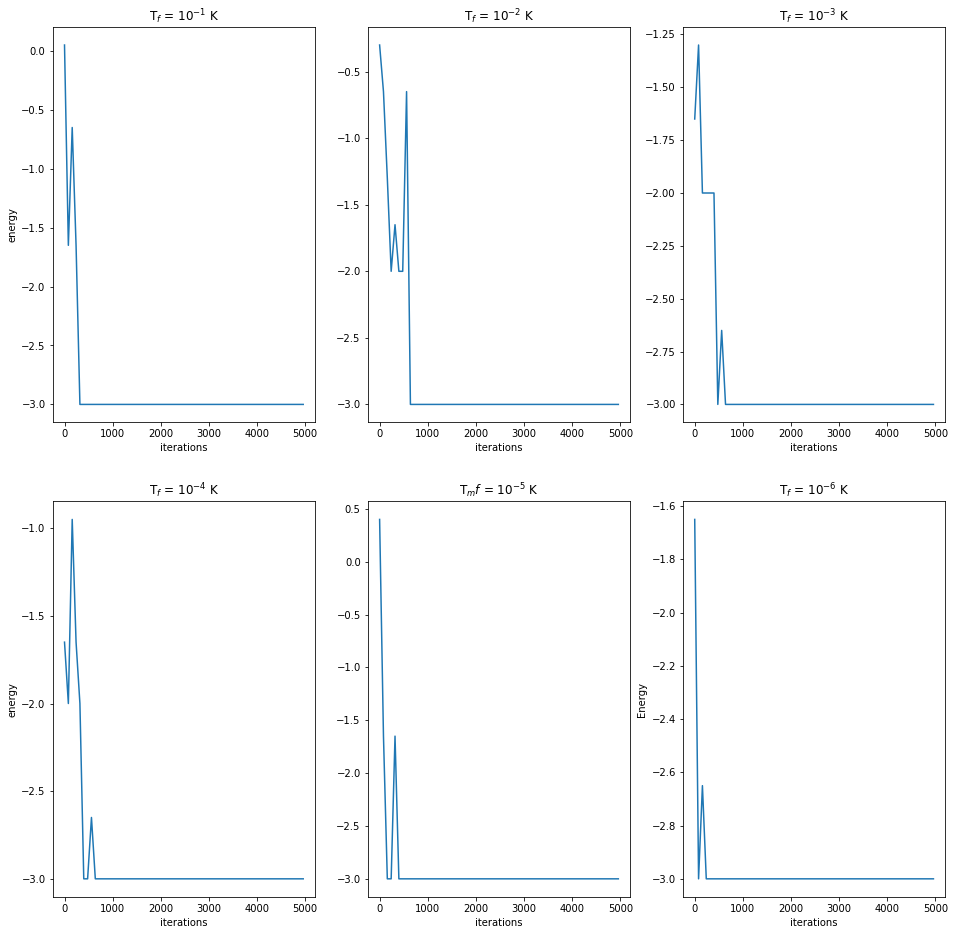

In [60]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(16,16))

axis[0,0].plot(x1,y1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,y2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,y3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,y4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,y5)
axis[1,1].set_title("T$_m{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,y6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")
plt.xlabel('iterations')
plt.ylabel('Energy')

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='energy')

[Text(0, 0.5, 'temperature'), Text(0, 0.5, 'temperature')]

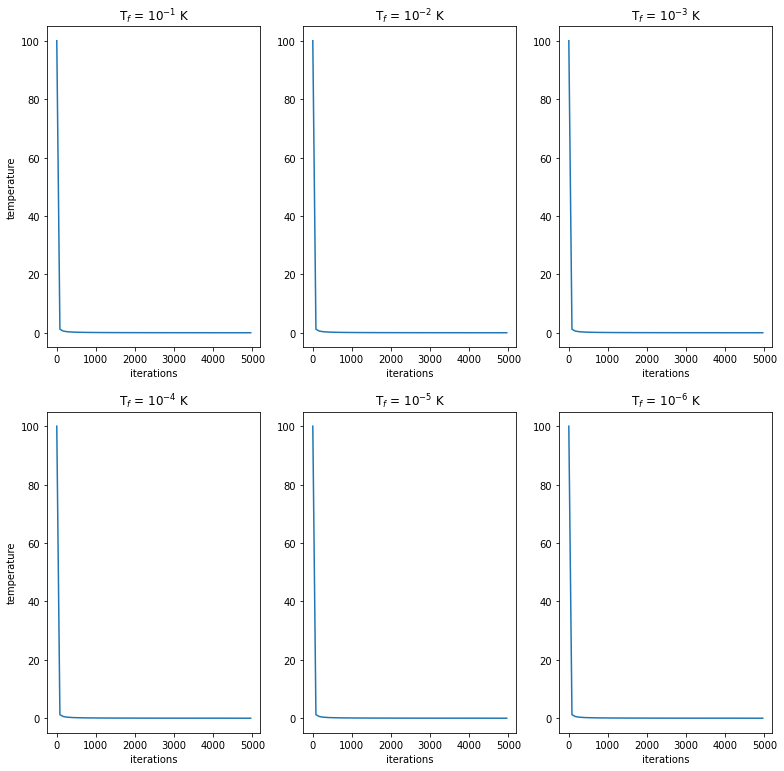

In [61]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(13,13))

axis[0,0].plot(x1,T1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,T2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,T3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,T4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,T5)
axis[1,1].set_title("T$_{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,T6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='temperature')

## Inverse Log Annealing Schedule
In this section, we'll use the inverse log annealing schedule (ie. T = ti * ((tf/ti) ** (t/N)))

In [62]:
# Grab our data points
(x1,y1,T1) = plot_coefficients('inverse_log', N, T_i, T_f_1)
(x2,y2,T2) = plot_coefficients('inverse_log', N, T_i, T_f_2)
(x3,y3,T3) = plot_coefficients('inverse_log', N, T_i, T_f_3)
(x4,y4,T4) = plot_coefficients('inverse_log', N, T_i, T_f_4)
(x5,y5,T5) = plot_coefficients('inverse_log', N, T_i, T_f_5)
(x6,y6,T6) = plot_coefficients('inverse_log', N, T_i, T_f_6)

[Text(0, 0.5, 'energy'), Text(0, 0.5, 'energy')]

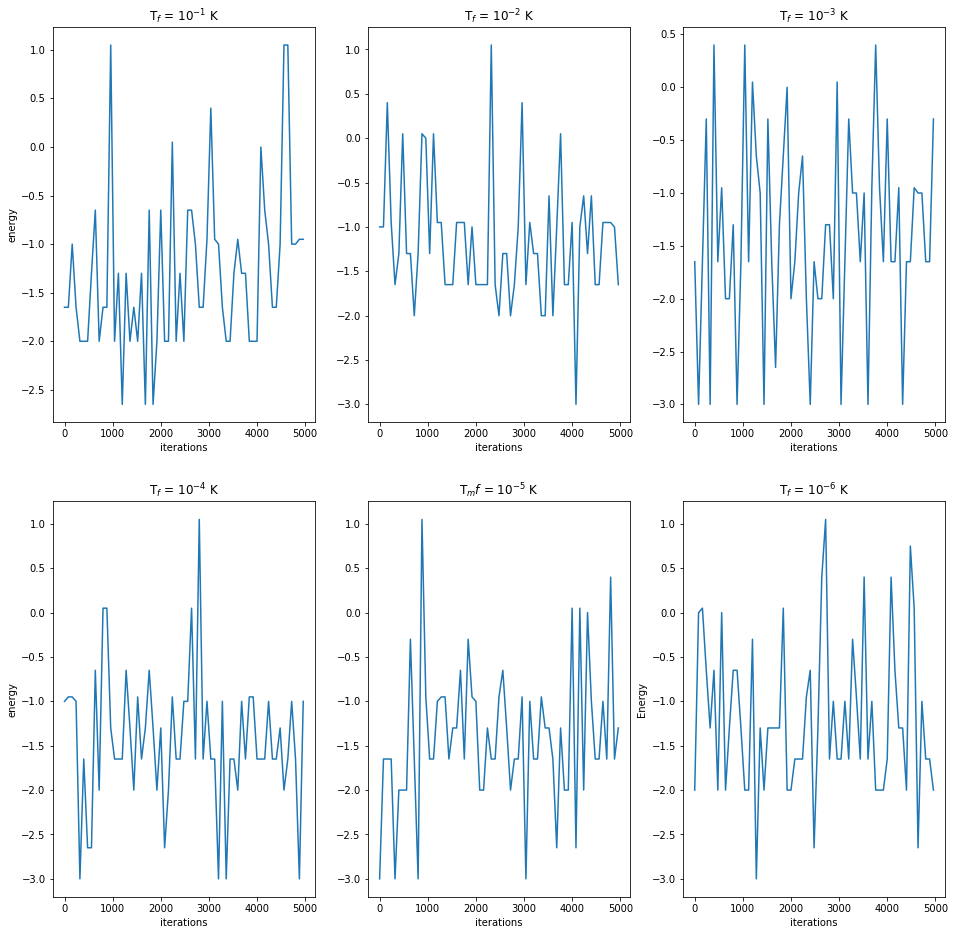

In [63]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(16,16))

axis[0,0].plot(x1,y1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,y2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,y3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,y4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,y5)
axis[1,1].set_title("T$_m{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,y6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")
plt.xlabel('iterations')
plt.ylabel('Energy')

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='energy')

[Text(0, 0.5, 'temperature'), Text(0, 0.5, 'temperature')]

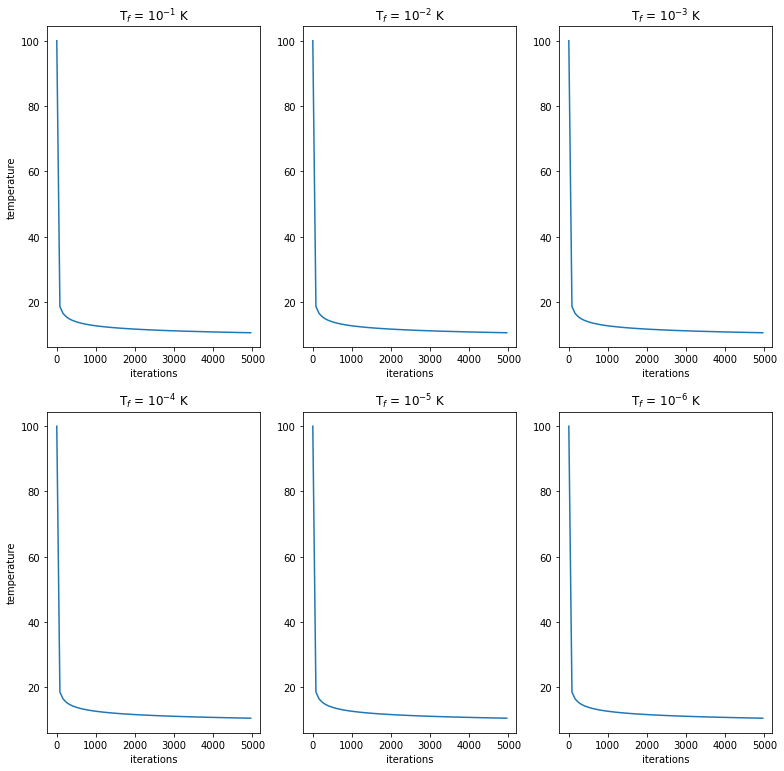

In [65]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(13,13))

axis[0,0].plot(x1,T1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,T2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,T3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,T4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,T5)
axis[1,1].set_title("T$_{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,T6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='temperature')

## Expontential Annealing Schedule
In this section, we'll use the expontential annealing schedule (ie. T = ti * ((tf/ti) ** (t/N)))

In [67]:
# Grab our data points
(x1,y1,T1) = plot_coefficients('exponential', N, T_i, T_f_1)
(x2,y2,T2) = plot_coefficients('exponential', N, T_i, T_f_2)
(x3,y3,T3) = plot_coefficients('exponential', N, T_i, T_f_3)
(x4,y4,T4) = plot_coefficients('exponential', N, T_i, T_f_4)
(x5,y5,T5) = plot_coefficients('exponential', N, T_i, T_f_5)
(x6,y6,T6) = plot_coefficients('exponential', N, T_i, T_f_6)

[Text(0, 0.5, 'energy'), Text(0, 0.5, 'energy')]

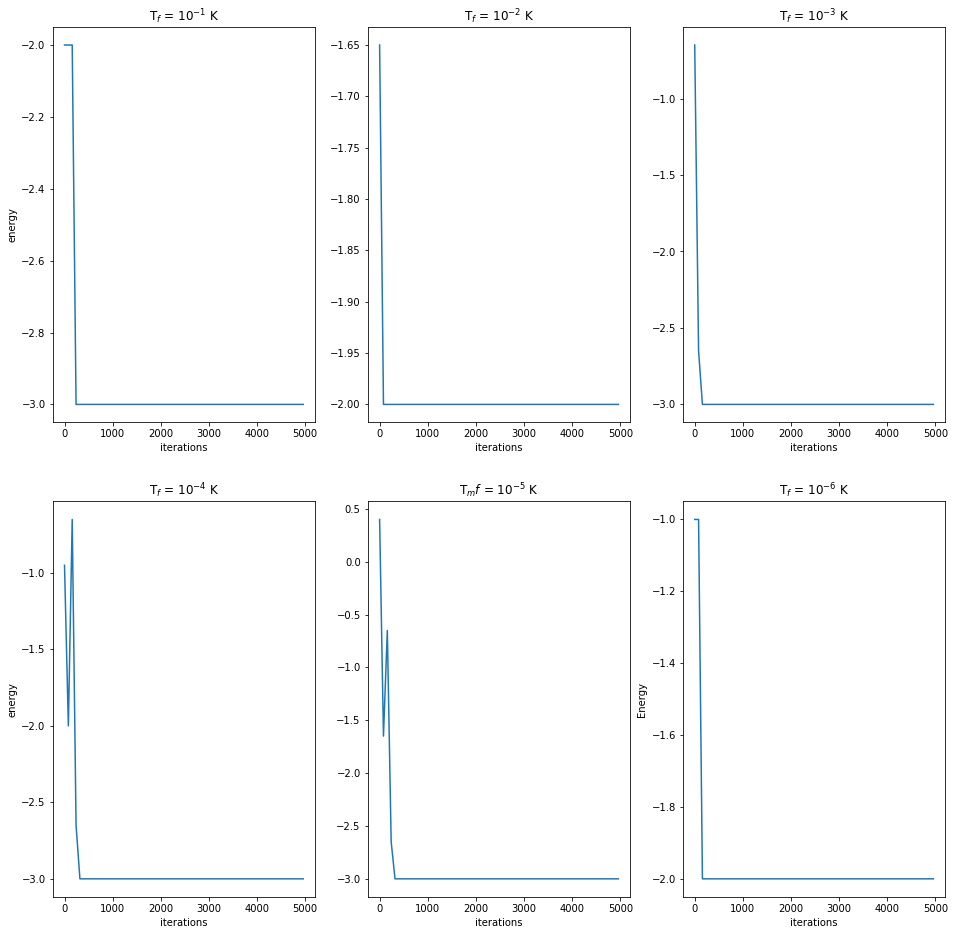

In [68]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(16,16))

axis[0,0].plot(x1,y1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,y2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,y3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,y4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,y5)
axis[1,1].set_title("T$_m{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,y6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")
plt.xlabel('iterations')
plt.ylabel('Energy')

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='energy')

[Text(0, 0.5, 'temperature'), Text(0, 0.5, 'temperature')]

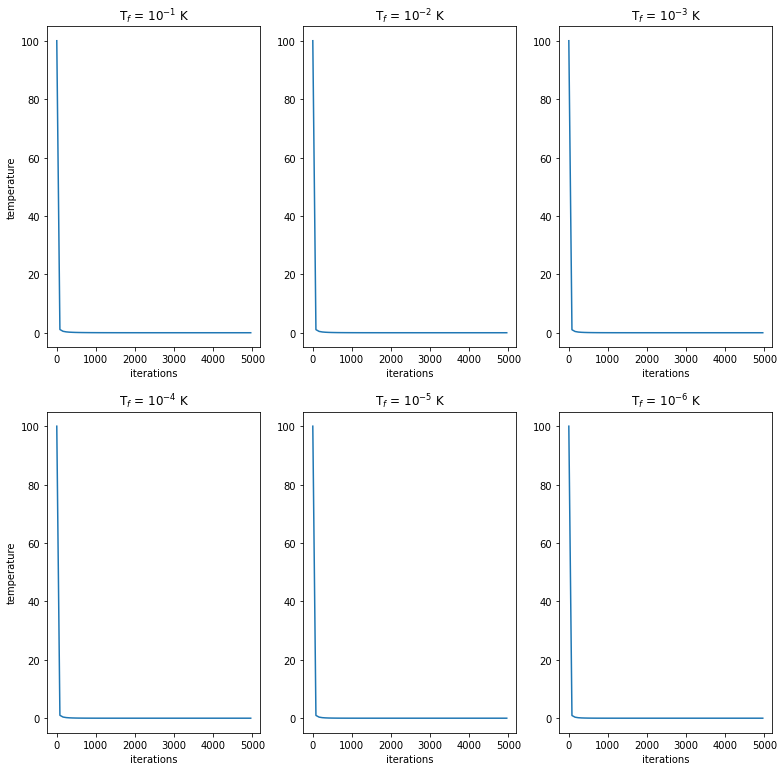

In [69]:
 # Individually plot each of the convergences
figure, axis = plt.subplots(2,3,figsize=(13,13))

axis[0,0].plot(x1,T1)
axis[0,0].set_title("T$_{f}$ = $10^{-1}$ K")

axis[0,1].plot(x2,T2)
axis[0,1].set_title("T$_{f}$ = $10^{-2}$ K")

axis[0,2].plot(x3,T3)
axis[0,2].set_title("T$_{f}$ = $10^{-3}$ K")

axis[1,0].plot(x4,T4)
axis[1,0].set_title("T$_{f}$ = $10^{-4}$ K")

axis[1,1].plot(x5,T5)
axis[1,1].set_title("T$_{f}$ = $10^{-5}$ K")

axis[1,2].plot(x6,T6)
axis[1,2].set_title("T$_{f}$ = $10^{-6}$ K")

# set labels
plt.setp(axis[0, :], xlabel='iterations')
plt.setp(axis[-1, :], xlabel='iterations')
plt.setp(axis[:, 0], ylabel='temperature')

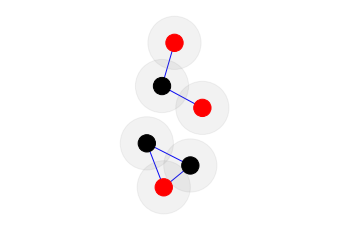

In [17]:
fig, ax = plt.subplots()

draw_graph_state(udmis, udmis.occupations, ax)